# Customer Shopping

## 0. Preparação

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
import sklearn.ensemble as en
import sklearn.decomposition as dd

import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


In [2]:
def jupyter_settings():
    """
    Plots pre settings.
    """

    %matplotlib inline
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24
    display(HTML("<style>.container {width:100% !important;}</style>"))
    sns.set_theme()


jupyter_settings()

seed = 42

In [3]:
def plot_features(data: pd.DataFrame, plot_type: str = "histplot") -> None:
    """
    Plots features of a DataFrame as either histograms or boxplots.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data to plot.
    plot_type (str): The type of plot to create. Must be either 'histplot' or 'boxplot'.
                    Default is 'histplot'.


    Raises:
    ValueError: If plot_type is not 'histplot' or 'boxplot'.

    Returns:
    None
    """
    if plot_type not in ["histplot", "boxplot"]:
        raise ValueError("plot_type must be either 'histplot' or 'boxplot'")

    count = 1

    plt.figure(figsize=(15, 10))

    for col in data.columns:
        plt.subplot(3, 4, count)

        if plot_type == "histplot":
            axes = sns.histplot(data=data, x=col, kde=True)
            axes.title.set_text(f"Histogram of {col}")
        elif plot_type == "boxplot":
            axes = sns.boxplot(data=data, x=col, orient="h")
            axes.title.set_text(f"Catching outliers in {col}")

        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        count += 1

    plt.show()

    return None


def categorical_metrics(data: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Shows the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        column ([str]): [Insert the column name]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """

    return pd.DataFrame(
        {
            "absolute": data[column].value_counts(),
            "percent %": data[column].value_counts(normalize=True) * 100,
        }
    )

In [4]:
def apply_standard_scaler(datasets: list, columns: list) -> None:
    """
    Applies Standard Scaling to specified columns in a list of datasets using sklearn
    StandardScaler,
    replacing the original columns in the DataFrames. Saves the scaler to a .pkl file.

    Args:
        datasets (list of pd.DataFrame): List of DataFrames where the scaling will be
        applied.
        columns (list of str): List of column names to which Standard Scaling will be
        applied.

    Returns:
        None
    """
    scaler = StandardScaler()

    for df in datasets:
        df[columns] = scaler.fit_transform(df[columns])

    return None


def apply_min_max_scaler(datasets: list, columns: list) -> None:
    """
    Applies Min-Max Scaling to specified columns in a list of datasets using sklearn
    MinMaxScaler,
    replacing the original columns in the DataFrames. Saves the scaler to a .pkl file.

    Args:
        datasets (list of pd.DataFrame): List of DataFrames where the scaling will be
        applied.
        columns (list of str): List of column names to which Min-Max Scaling will be
        applied.

    Returns:
        None
    """
    scaler = MinMaxScaler()

    for df in datasets:
        df[columns] = scaler.fit_transform(df[columns])

    return None

In [65]:
def silhouette_score_result(clusters, model_list, color):
    """Generates a silhouette score of one model
    Args:
        clusters: [A list with clusters]
        model_list: [A list of the model labels info]
        color: [Color of the line]
    Returns:
        [Image]: [Silhouette Score]
    """

    ax = plt.plot(clusters, model_list, linestyle="--", marker="o", color=color)
    plt.xlabel("Cluster")
    plt.xticks(clusters)
    plt.ylabel("Silhouette Score")
    plt.title("Gaussian Mixture Silhouette Score")

    return ax

In [5]:
# Lendo os dados brutos e salvando em parquet
main_path = Path().resolve().parent

# Só faz isso se não existir o arquivo parquet
if not (main_path / "data" / "interim" / "customer_shopping_data.parquet").exists():
    data_path = main_path / "data" / "raw" / "customer_shopping_data.csv"

    data_raw = pd.read_csv(data_path)
    parquet_file = data_raw.to_parquet(
        main_path / "data" / "interim" / "customer_shopping_data.parquet"
    )
    print("Arquivo parquet criado com sucesso!")
else:
    print("Arquivo parquet já existe!")


Arquivo parquet já existe!


## 1. Descrição dos dados

In [6]:
df1 = pd.read_parquet(main_path / "data" / "interim" / "customer_shopping_data.parquet")
df1.head().T

,0,1,2,3,4
invoice_no,I138884,I317333,I127801,I173702,I337046
customer_id,C241288,C111565,C266599,C988172,C189076
gender,Female,Male,Male,Female,Female
age,28,21,20,66,53
category,Clothing,Shoes,Clothing,Shoes,Books
quantity,5,3,1,5,4
price,1500.4,1800.51,300.08,3000.85,60.6
payment_method,Credit Card,Debit Card,Cash,Credit Card,Cash
invoice_date,5/8/2022,12/12/2021,9/11/2021,16/05/2021,24/10/2021
shopping_mall,Kanyon,Forum Istanbul,Metrocity,Metropol AVM,Kanyon


In [7]:
df1.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [9]:
# Verificando se existem valores iguais a zero
df1.min()

invoice_no            I100008
customer_id           C100004
gender                 Female
age                        18
category                Books
quantity                    1
price                    5.23
payment_method           Cash
invoice_date         1/1/2021
shopping_mall     Cevahir AVM
dtype: object

In [10]:
# Verificando se existem valores duplicados
df1.duplicated().sum()

0

In [11]:
# Verificando a quantidade de valores únicos
df1.nunique()

invoice_no        99457
customer_id       99457
gender                2
age                  52
category              8
quantity              5
price                40
payment_method        3
invoice_date        797
shopping_mall        10
dtype: int64

In [12]:
# Verificando quais são os valores únicos
print(f"Categoria: {df1['category'].unique()}")
print(f"Quantidade: {df1['quantity'].unique()}")
print(f"Forma de Pagamento: {df1['payment_method'].unique()}")
print(f"Shopping: {df1['shopping_mall'].unique()}")

Categoria: ['Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys'
 'Technology' 'Souvenir']
Quantidade: [5 3 1 4 2]
Forma de Pagamento: ['Credit Card' 'Debit Card' 'Cash']
Shopping: ['Kanyon' 'Forum Istanbul' 'Metrocity' 'Metropol AVM' 'Istinye Park'
 'Mall of Istanbul' 'Emaar Square Mall' 'Cevahir AVM' 'Viaport Outlet'
 'Zorlu Center']


In [13]:
# Features numéricas
num_features = df1.select_dtypes(include=["int64", "float64"]).columns
# Features categóricas
cat_features = df1.select_dtypes(include=["object"]).columns

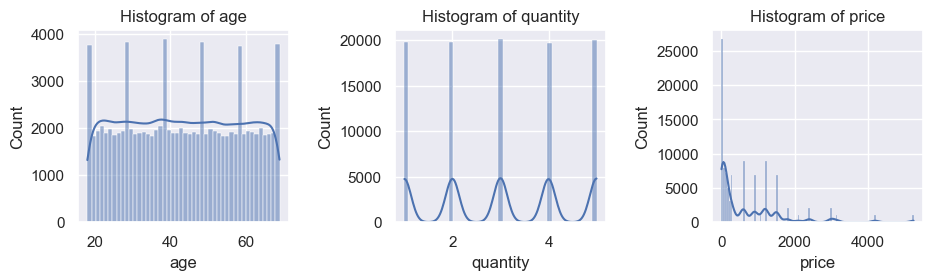

In [14]:
# Criando um histograma para as features numéricas
plot_features(df1[num_features], plot_type="histplot")

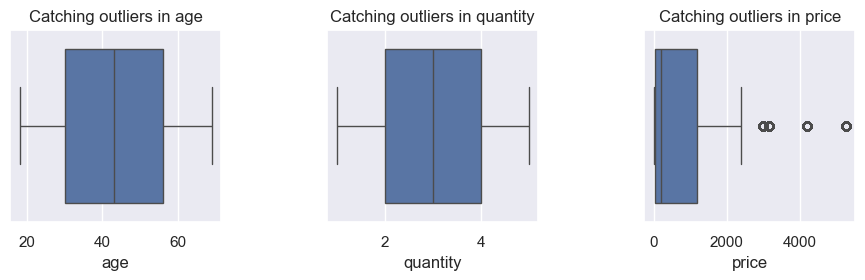

In [15]:
# Criando um boxplot para as features numéricas
plot_features(df1[num_features], plot_type="boxplot")

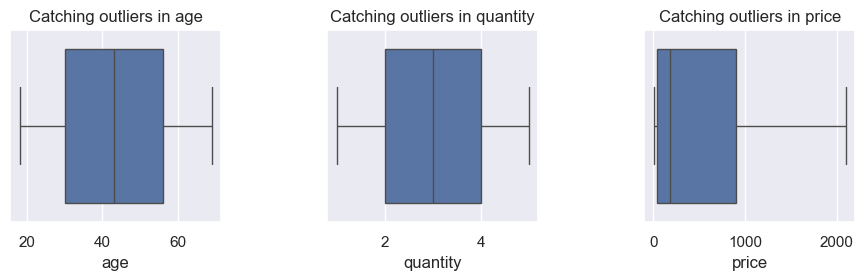

In [16]:
# Limitando o preço para até 2400
df1_without_outliers = df1[df1["price"] < 2400]
plot_features(df1_without_outliers[num_features], plot_type="boxplot")

In [17]:
# Comparando quantas linhas seriam perdidas se fossem removidos os outliers
print(f"Quantidade de linhas perdidas: {df1.shape[0] - df1_without_outliers.shape[0]}")

Quantidade de linhas perdidas: 7046


In [18]:
# Verificando o que são esses outliers
df1_outliers = df1[df1["price"] >= 2400]
df1_outliers.describe()

,age,quantity,price
count,7046.000000,7046.000000,7046.000000
mean,43.469344,4.284559,3339.864605
std,14.886182,0.700042,956.402980
min,18.000000,3.000000,2400.680000
25%,31.000000,4.000000,2400.680000
50%,43.000000,4.000000,3000.850000
75%,56.000000,5.000000,4200.000000
max,69.000000,5.000000,5250.000000


In [19]:
df1_outliers.min()

invoice_no            I100027
customer_id           C100168
gender                 Female
age                        18
category                Shoes
quantity                    3
price                 2400.68
payment_method           Cash
invoice_date         1/1/2021
shopping_mall     Cevahir AVM
dtype: object

In [20]:
df1_outliers.nunique()

invoice_no        7046
customer_id       7046
gender               2
age                 52
category             2
quantity             3
price                5
payment_method       3
invoice_date       797
shopping_mall       10
dtype: int64

In [21]:
print(f"Categoria: {df1_outliers['category'].unique()}")

Categoria: ['Shoes' 'Technology']


In [22]:
df1_outliers["category"].value_counts()

category
Shoes         4035
Technology    3011
Name: count, dtype: int64

In [23]:
df1_outliers.sample(10).T

,62173,78178,90848,28541,29294,53448,11658,29939,23530,38797
invoice_no,I287137,I450578,I325654,I890980,I155095,I316917,I187049,I328905,I677719,I191895
customer_id,C384417,C286882,C185832,C143080,C244310,C318199,C594446,C115908,C113263,C857146
gender,Female,Female,Female,Male,Female,Male,Female,Female,Female,Female
age,50,50,61,28,24,54,28,33,48,49
category,Shoes,Shoes,Shoes,Shoes,Shoes,Technology,Shoes,Technology,Shoes,Shoes
quantity,4,5,4,5,4,3,5,4,5,5
price,2400.68,3000.85,2400.68,3000.85,2400.68,3150.0,3000.85,4200.0,3000.85,3000.85
payment_method,Cash,Credit Card,Cash,Credit Card,Credit Card,Debit Card,Cash,Credit Card,Cash,Cash
invoice_date,15/08/2021,2/5/2022,10/8/2021,1/12/2021,21/03/2021,13/09/2022,13/04/2022,16/06/2022,6/9/2021,13/03/2022
shopping_mall,Mall of Istanbul,Kanyon,Zorlu Center,Istinye Park,Kanyon,Mall of Istanbul,Cevahir AVM,Forum Istanbul,Emaar Square Mall,Kanyon


Esses outliers vem de somente duas categorias, sapatos e tecnologia, dois setores que podem sim custar muito, entretanto, por serem apenas 7000, irei descartar, dada a quantidade de dados que temos.

In [24]:
df1 = df1_without_outliers

In [25]:
cat_features

Index(['invoice_no', 'customer_id', 'gender', 'category', 'payment_method',
       'invoice_date', 'shopping_mall'],
      dtype='object')

In [26]:
categorical_metrics(df1, "gender")

,absolute,percent %
gender,,
Female,55295,59.83595
Male,37116,40.16405


In [27]:
categorical_metrics(df1, "category")

,absolute,percent %
category,,
Clothing,34487,37.319150
Cosmetics,15097,16.336800
Food & Beverage,14776,15.989438
Toys,10087,10.915367
Shoes,5999,6.491651
Souvenir,4999,5.409529
Books,4981,5.390051
Technology,1985,2.148013


In [28]:
categorical_metrics(df1, "payment_method")

,absolute,percent %
payment_method,,
Cash,41280,44.670007
Credit Card,32427,35.089978
Debit Card,18704,20.240015


In [29]:
categorical_metrics(df1, "shopping_mall")

,absolute,percent %
shopping_mall,,
Mall of Istanbul,18512,20.032247
Kanyon,18398,19.908885
Metrocity,13983,15.131316
Metropol AVM,9452,10.228220
Istinye Park,9080,9.825670
Zorlu Center,4704,5.090303
Cevahir AVM,4634,5.014555
Forum Istanbul,4608,4.986419
Viaport Outlet,4566,4.940970


Data

In [30]:
df1["invoice_date"] = pd.to_datetime(
    df1["invoice_date"], errors="coerce", dayfirst=True
)

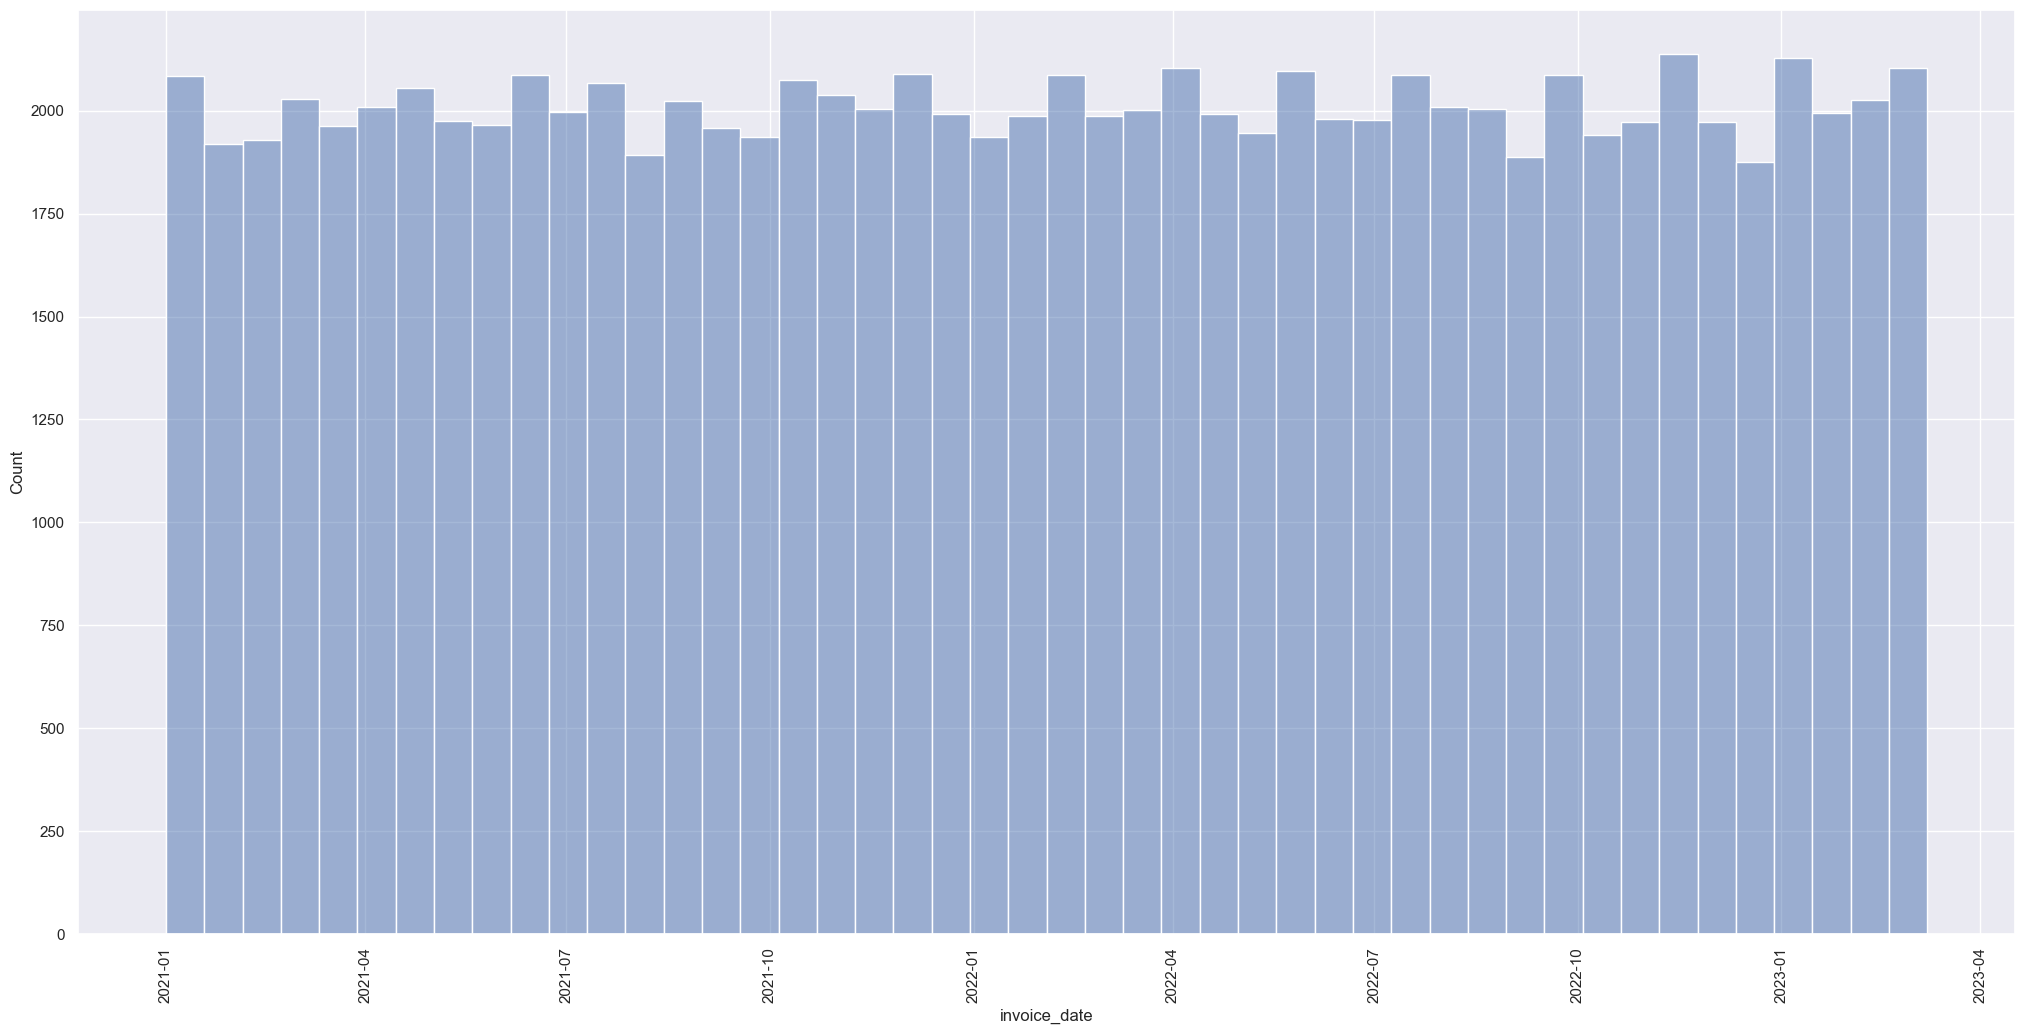

In [31]:
ax = sns.histplot(data=df1, x="invoice_date", alpha=0.5)
plt.xticks(rotation=90);

## 2. Feature Engineering

In [32]:
df1.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [33]:
print(f"Valor mínimo: {df1["price"].min()}")
print(f"Valor maximo: {df1["price"].max()}")

Valor mínimo: 5.23
Valor maximo: 2100.0


In [34]:
# Nessa situação, irei utilizar aprendizado não supervisionado,
# Pensando nisso, vamos criar algumas features, além do RFM
df2 = df1.copy()

# Criando a feature de receita bruta
df2.loc[:, "gross_revenue"] = df2.loc[:, "quantity"] * df2.loc[:, "price"]

# Criando a feature de ticket médio
df_avg_ticket = (
    df2.loc[:, ["customer_id", "gross_revenue"]]
    .groupby("customer_id")
    .mean()
    .reset_index()
    .rename(columns={"gross_revenue": "avg_ticket"})
)
df_avg_ticket.columns = ["customer_id", "avg_ticket"]
# merge
df2 = pd.merge(df2, df_avg_ticket, on="customer_id", how="left")

# Criando a feature de quantidade de itens comprados
df_qoip = (
    df2.loc[:, ["customer_id", "quantity"]].groupby("customer_id").sum().reset_index()
)
df_qoip.columns = ["customer_id", "quantity_of_items_purchased"]
# merge
df2 = pd.merge(df2, df_qoip, on="customer_id", how="left")

# Criando a feature de frequência de compra
df_pfreq = (
    df2.loc[:, ["customer_id", "invoice_no", "invoice_date"]]
    .drop_duplicates()
    .groupby("customer_id")
    .agg(
        max_=("invoice_date", "max"),
        min_=("invoice_date", "min"),
        days_=("invoice_date", lambda x: ((x.max() - x.min()).days) + 1),
        buy_=("invoice_no", "count"),
    )
).reset_index()

df_pfreq["purchase_frequency"] = df_pfreq[["buy_", "days_"]].apply(
    lambda x: x["buy_"] / x["days_"] if x["days_"] != 0 else 0, axis=1
)
df_pfreq = df_pfreq[["customer_id", "purchase_frequency"]]
# merge
df2 = pd.merge(df2, df_pfreq, on="customer_id", how="left")

# Criando a feature de tamanho da cesta
df_basket_size = (
    df2.loc[:, ["customer_id", "invoice_no", "quantity"]]
    .groupby("customer_id")
    .agg(n_purchase=("invoice_no", "nunique"), n_products=("quantity", "sum"))
).reset_index()

df_basket_size["avg_basket_size"] = (
    df_basket_size["n_products"] / df_basket_size["n_purchase"]
)
df_basket_size = df_basket_size[["customer_id", "avg_basket_size"]]
# merge
df2 = pd.merge(df2, df_basket_size, how="left", on="customer_id")

# Criando a feature de recência
df_recency = (
    df2.loc[:, ["customer_id", "invoice_date"]]
    .groupby("customer_id")
    .max()
    .reset_index()
)
df_recency["recency"] = (df2["invoice_date"].max() - df_recency["invoice_date"]).dt.days
df_recency.drop(["invoice_date"], axis=1, inplace=True)
# merge
df2 = pd.merge(df2, df_recency, on="customer_id", how="left")

# Criando a feature de frequência
df_purchased = (
    df2.loc[:, ["customer_id", "invoice_no"]]
    .groupby("customer_id")
    .count()
    .reset_index()
)
df_purchased.columns = ["customer_id", "frequency"]
# merge
df2 = pd.merge(df2, df_purchased, on="customer_id", how="left")

# Criando a feature de monetização
df_monetary = (
    df2.loc[:, ["customer_id", "gross_revenue"]]
    .groupby("customer_id")
    .sum()
    .reset_index()
)
df_monetary.columns = ["customer_id", "monetary"]
# merge
df2 = pd.merge(df2, df_monetary, on="customer_id", how="left")

In [35]:
df2.head().T

,0,1,2,3,4
invoice_no,I138884,I317333,I127801,I337046,I227836
customer_id,C241288,C111565,C266599,C189076,C657758
gender,Female,Male,Male,Female,Female
age,28,21,20,53,28
category,Clothing,Shoes,Clothing,Books,Clothing
quantity,5,3,1,4,5
price,1500.4,1800.51,300.08,60.6,1500.4
payment_method,Credit Card,Debit Card,Cash,Cash,Credit Card
invoice_date,2022-08-05 00:00:00,2021-12-12 00:00:00,2021-11-09 00:00:00,2021-10-24 00:00:00,2022-05-24 00:00:00
shopping_mall,Kanyon,Forum Istanbul,Metrocity,Kanyon,Forum Istanbul


In [36]:
# Verificando se existem valores nulos
df2.isnull().sum()

invoice_no                     0
customer_id                    0
gender                         0
age                            0
category                       0
quantity                       0
price                          0
payment_method                 0
invoice_date                   0
shopping_mall                  0
gross_revenue                  0
avg_ticket                     0
quantity_of_items_purchased    0
purchase_frequency             0
avg_basket_size                0
recency                        0
frequency                      0
monetary                       0
dtype: int64

## 3. Clusterização

Nessa situação, irei utilizar somente as features criadas, já que fornecem métricas importantes pro negócio, além disso, irei manter a forma de pagamento e shopping, já que aparentam ser relevante na análise.

Como o PCA, t-sne e UMAP são sensíveis a escala das variáveis, irei fazer uma normalização

### 3.1 Encoding e Normalização

In [37]:
df3 = df2.copy()
df3_cluster = df3[
    [
        "payment_method",
        "shopping_mall",
        "gross_revenue",
        "avg_ticket",
        "quantity_of_items_purchased",
        "purchase_frequency",
        "avg_basket_size",
        "recency",
        "frequency",
        "monetary",
    ]
]

df3_cluster.head().T

,0,1,2,3,4
payment_method,Credit Card,Debit Card,Cash,Cash,Credit Card
shopping_mall,Kanyon,Forum Istanbul,Metrocity,Kanyon,Forum Istanbul
gross_revenue,7502.0,5401.53,300.08,242.4,7502.0
avg_ticket,7502.0,5401.53,300.08,242.4,7502.0
quantity_of_items_purchased,5,3,1,4,5
purchase_frequency,1.0,1.0,1.0,1.0,1.0
avg_basket_size,5.0,3.0,1.0,4.0,5.0
recency,215,451,484,500,288
frequency,1,1,1,1,1
monetary,7502.0,5401.53,300.08,242.4,7502.0


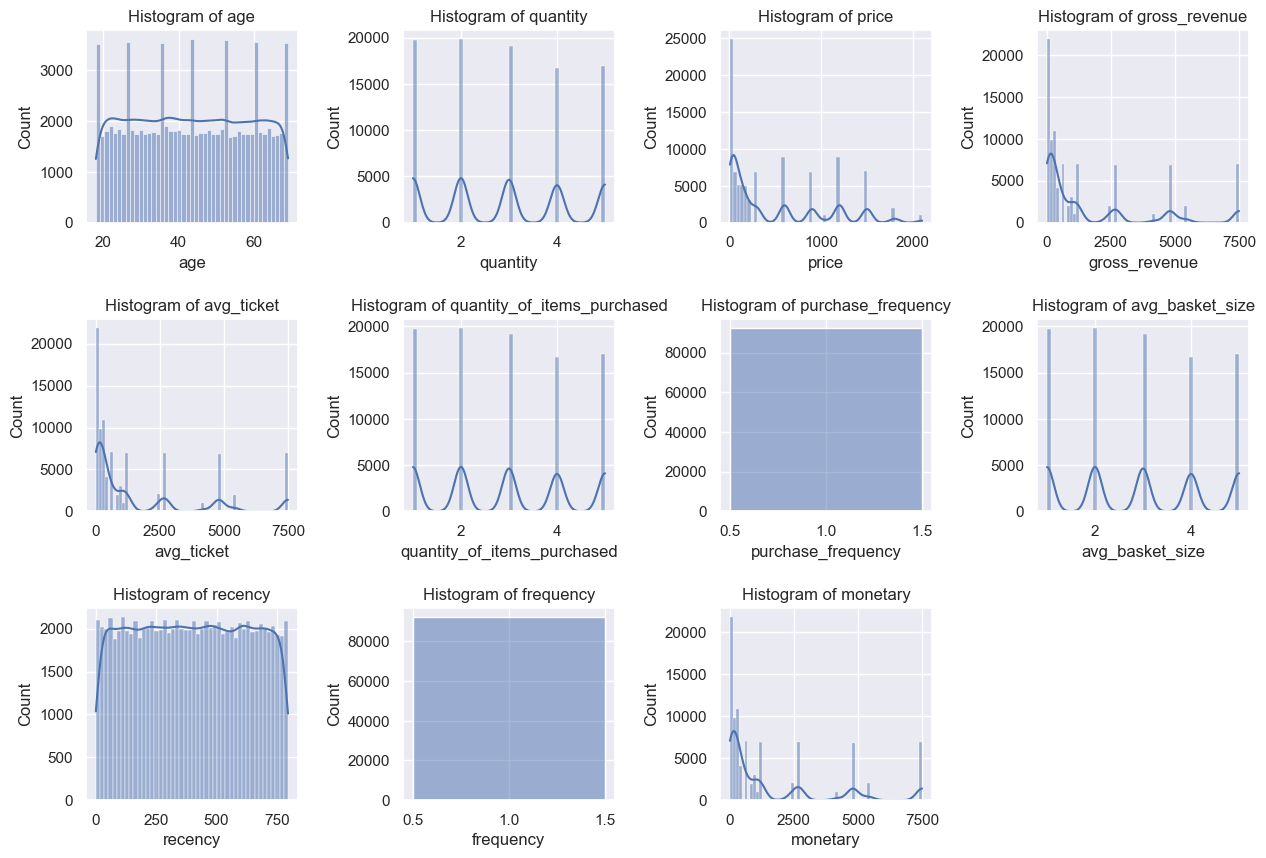

In [38]:
num_features = df3.select_dtypes(include=["int64", "float64"]).columns
plot_features(df3[num_features], plot_type="histplot")

In [39]:
"""
Standard Scaler: Features que seguem uma distribuição normal ou quando você quer
                    padronizar com média 0 e desvio padrão 1.

Min Max Scaler: Features que não seguem uma distribuição normal e a escala é
                desconhecida.

Robust Scaler: Features com outliers e que não seguem uma distribuição normal.
"""

standard_scaler = ["avg_ticket", "avg_basket_size"]

min_max_scaler = [
    "gross_revenue",
    "quantity_of_items_purchased",
    "purchase_frequency",
    "recency",
    "frequency",
    "monetary",
]

apply_standard_scaler([df3_cluster], standard_scaler)
apply_min_max_scaler([df3_cluster], min_max_scaler)

/var/folders/2p/4b88v851435gwxsql5mwn98w0000gn/T/ipykernel_27745/4104189496.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = scaler.fit_transform(df[columns])
/var/folders/2p/4b88v851435gwxsql5mwn98w0000gn/T/ipykernel_27745/4104189496.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = scaler.fit_transform(df[columns])


In [40]:
# Aplicar o Frequency Encoding na coluna 'payment_method'
freq_encoding_payment = df3_cluster["payment_method"].value_counts(normalize=True)
df3_cluster.loc[:, "payment_method_encoded"] = df3_cluster["payment_method"].map(
    freq_encoding_payment
)
df3_cluster.drop(columns=["payment_method"], inplace=True)

# Aplicar o Frequency Encoding na coluna 'shopping_mall'
freq_encoding_mall = df3_cluster["shopping_mall"].value_counts(normalize=True)
df3_cluster.loc[:, "shopping_mall_encoded"] = df3_cluster["shopping_mall"].map(
    freq_encoding_mall
)
df3_cluster.drop(columns=["shopping_mall"], inplace=True)


/var/folders/2p/4b88v851435gwxsql5mwn98w0000gn/T/ipykernel_27745/1981490848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_cluster.loc[:, "payment_method_encoded"] = df3_cluster["payment_method"].map(
/var/folders/2p/4b88v851435gwxsql5mwn98w0000gn/T/ipykernel_27745/1981490848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_cluster.drop(columns=["payment_method"], inplace=True)
/var/folders/2p/4b88v851435gwxsql5mwn98w0000gn/T/ipykernel_27745/1981490848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [41]:
df3_cluster.head().T

,0,1,2,3,4
gross_revenue,1.000000,0.719817,0.039330,0.031636,1.000000
avg_ticket,2.621095,1.685870,-0.585528,-0.611210,2.621095
quantity_of_items_purchased,1.000000,0.500000,0.000000,0.750000,1.000000
purchase_frequency,0.000000,0.000000,0.000000,0.000000,0.000000
avg_basket_size,1.489521,0.067037,-1.355448,0.778279,1.489521
recency,0.270101,0.566583,0.608040,0.628141,0.361809
frequency,0.000000,0.000000,0.000000,0.000000,0.000000
monetary,1.000000,0.719817,0.039330,0.031636,1.000000
payment_method_encoded,0.350900,0.202400,0.446700,0.446700,0.350900
shopping_mall_encoded,0.199089,0.049864,0.151313,0.199089,0.049864


### 3.2 PCA

In [42]:
def plot_label(title, xlabel, ylabel, fontsize):
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    sns.set_context("notebook")


data = df3_cluster.copy()

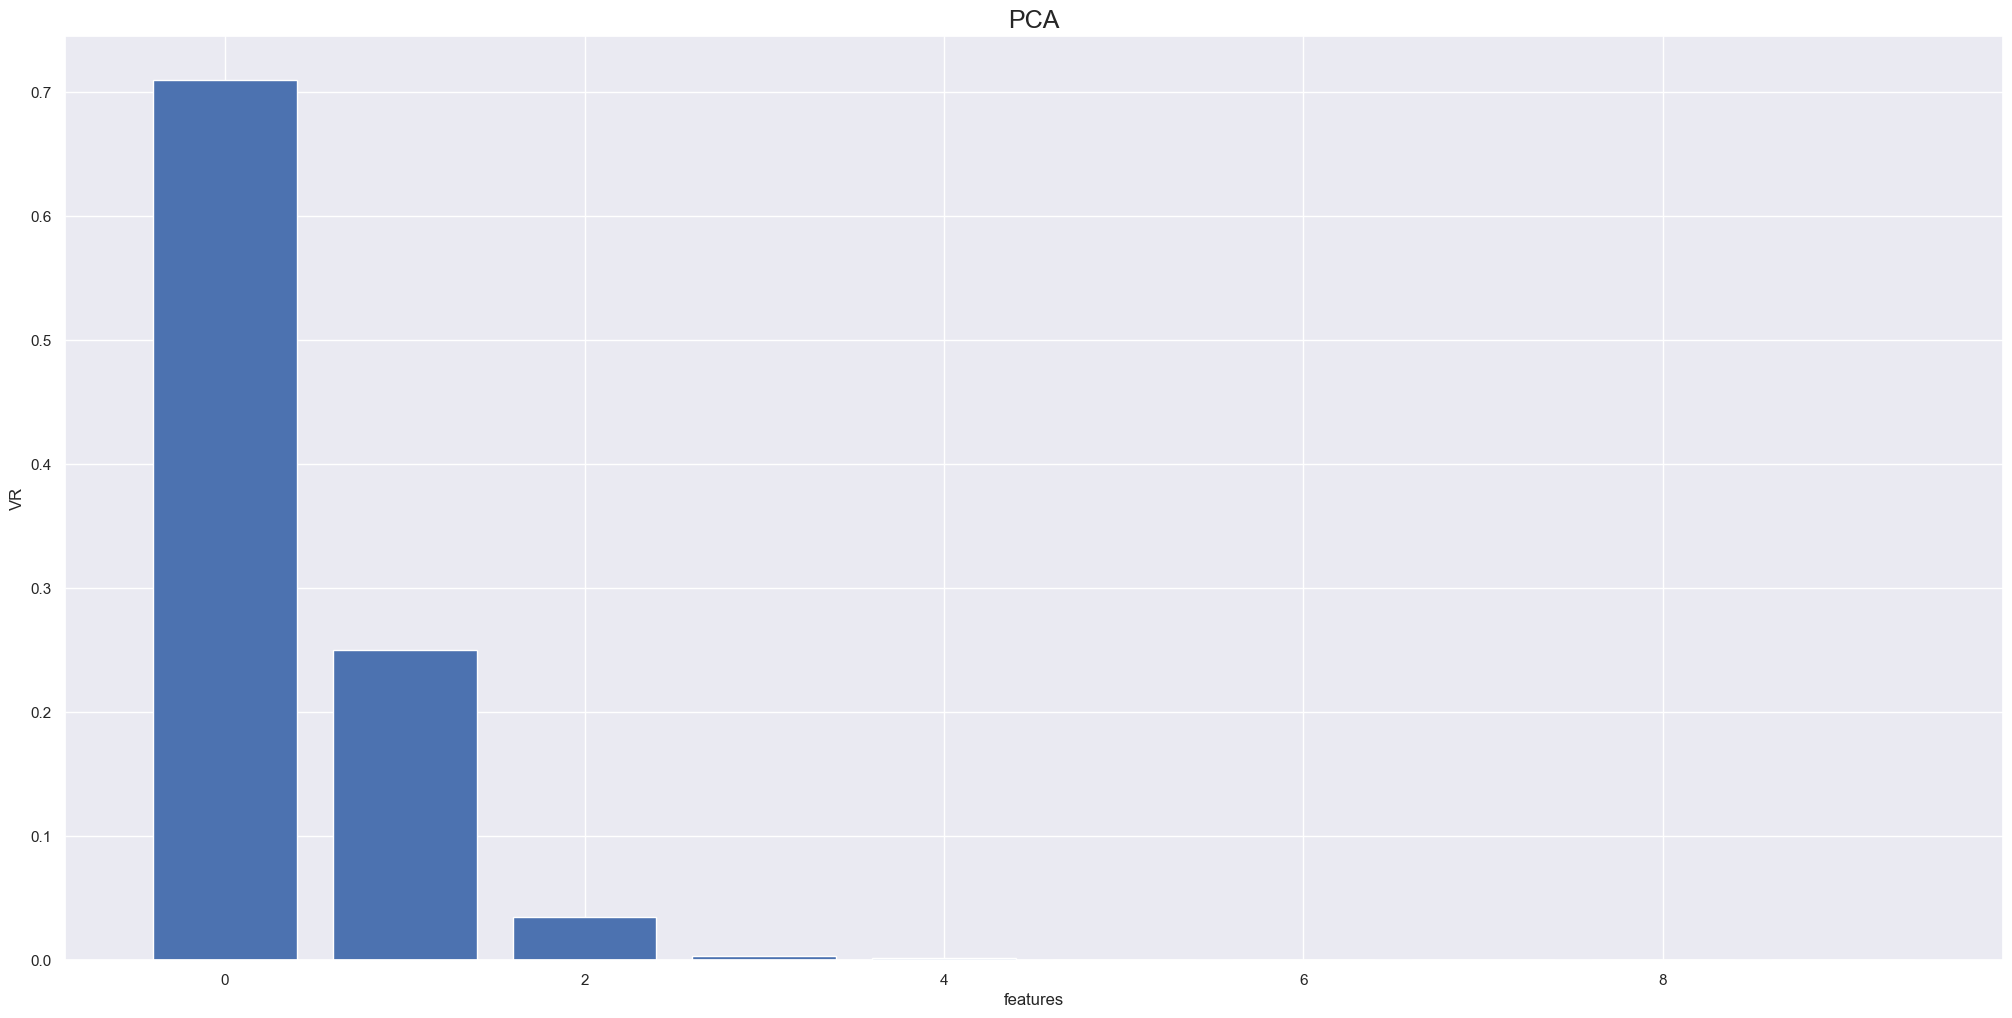

In [43]:
pca = dd.PCA(n_components=data.shape[1])
principal_components = pca.fit_transform(data)

# plot
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plot_label("PCA", "features", "VR", 12)

# pca component
df_pca = pd.DataFrame(principal_components)


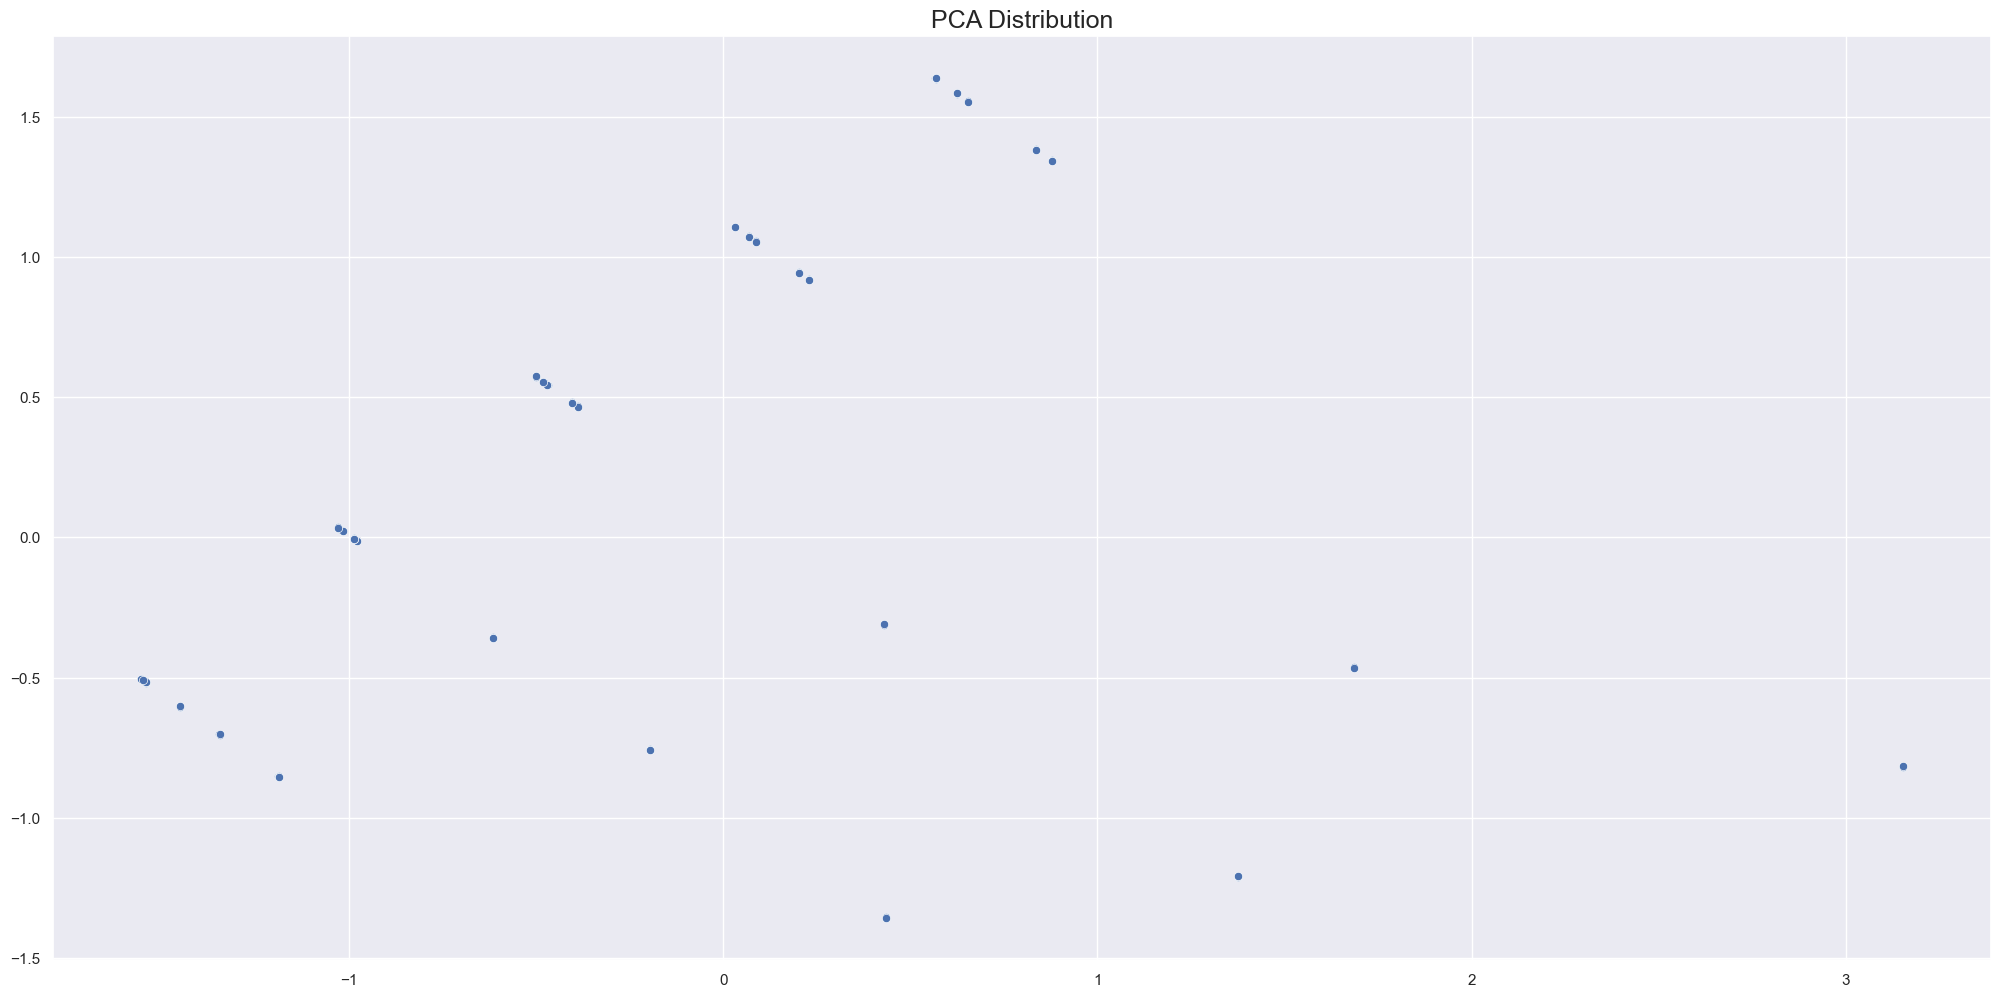

In [44]:
sns.scatterplot(x=0, y=1, data=df_pca)
plot_label("PCA Distribution", "", "", 12);

### 3.3 TSNE

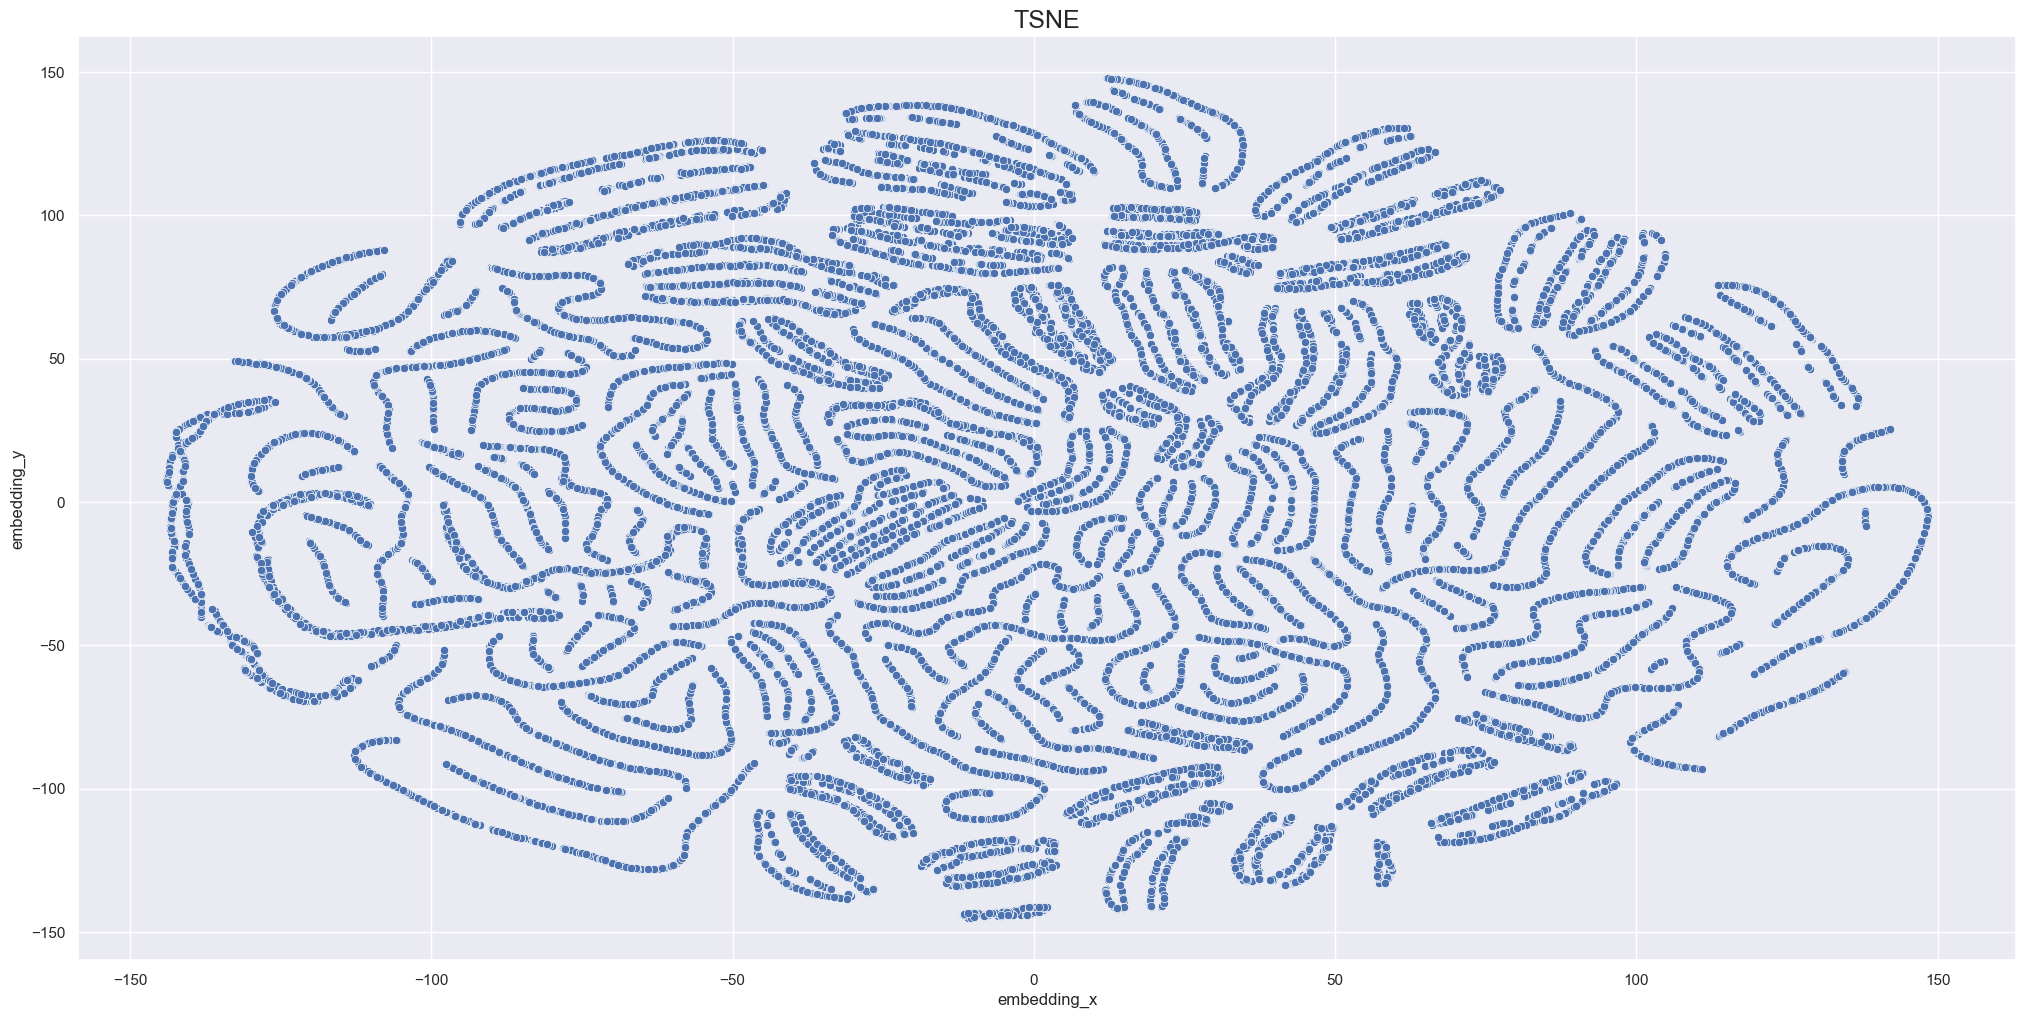

In [46]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=seed)
embedding = reducer.fit_transform(data)

# embedding
df_pca["embedding_x"] = embedding[:, 0]
df_pca["embedding_y"] = embedding[:, 1]

# plot
sns.scatterplot(x="embedding_x", y="embedding_y", data=df_pca)
plot_label("TSNE", "embedding_x", "embedding_y", 12);

### 3.4 UMAP

/Users/gutto/Repos/atividade-ia/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


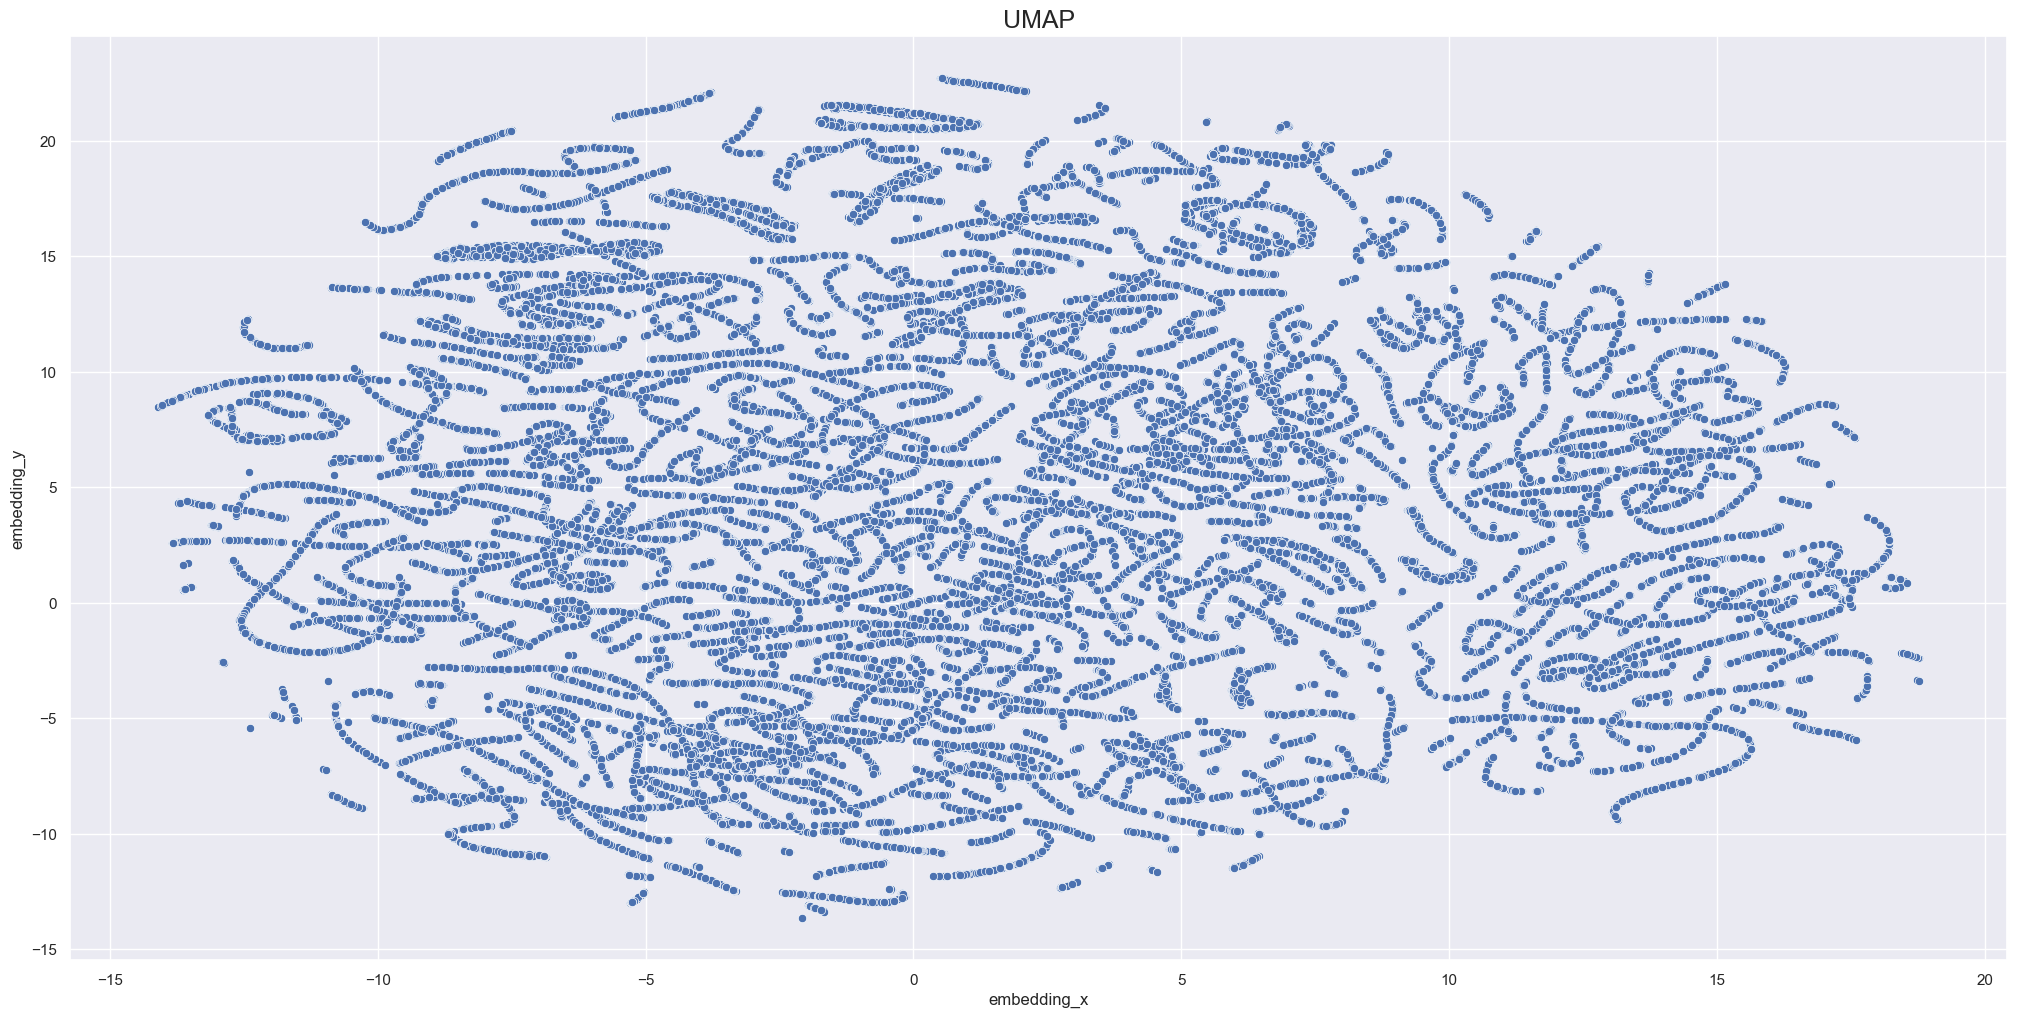

In [47]:
reducer = umap.UMAP(random_state=seed)
embedding = reducer.fit_transform(data)

# embedding
df_pca["embedding_x"] = embedding[:, 0]
df_pca["embedding_y"] = embedding[:, 1]

# plot
sns.scatterplot(x="embedding_x", y="embedding_y", data=df_pca)
plot_label("UMAP", "embedding_x", "embedding_y", 12);

### 3.5 Tree Based UMAP

In [48]:
X = data.drop(["monetary"], axis=1)
y = data["monetary"]

# model
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=seed)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [49]:
df_leaf = pd.DataFrame(rf_model.apply(X))

print(f"X.shape: {X.shape}\ndf_leaf.shape: {df_leaf.shape}")

X.shape: (92411, 9)
df_leaf.shape: (92411, 100)


/Users/gutto/Repos/atividade-ia/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/gutto/Repos/atividade-ia/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


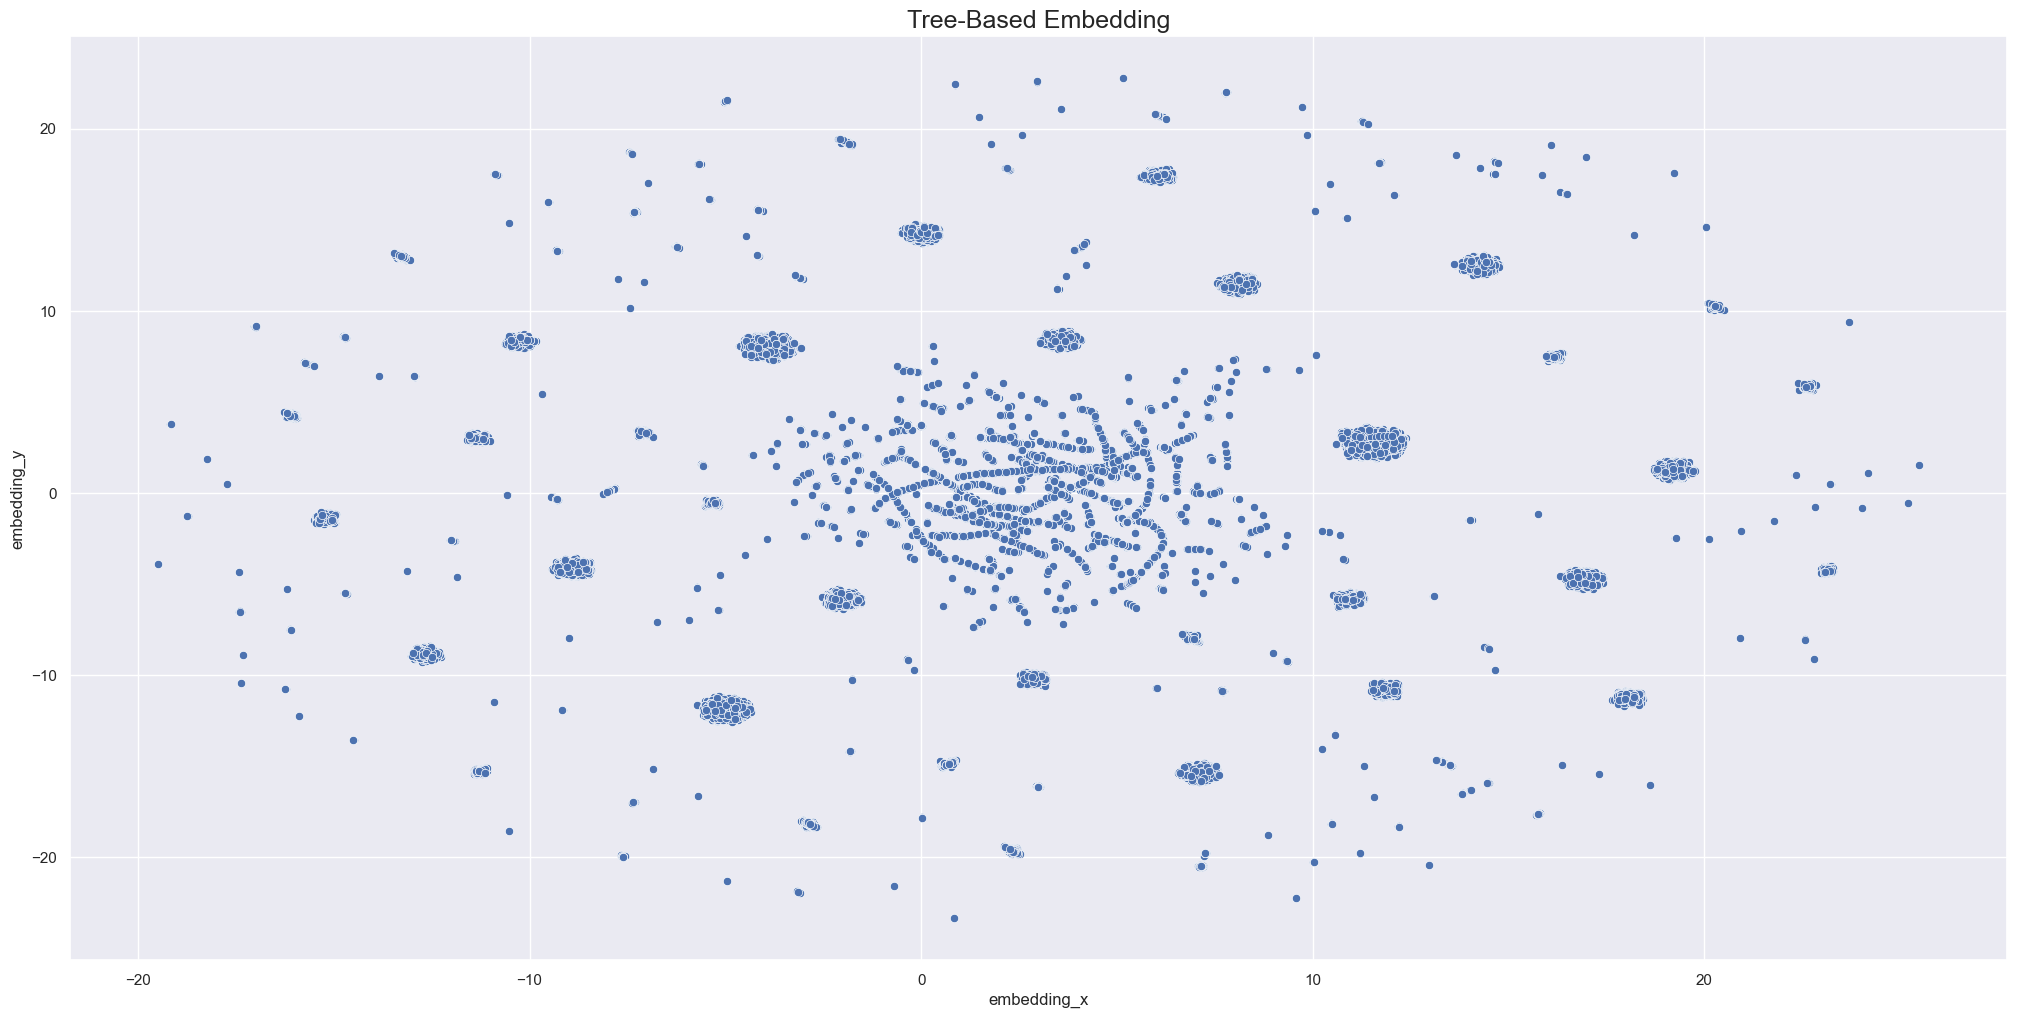

In [50]:
reducer = umap.UMAP(random_state=seed)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree["embedding_x"] = embedding[:, 0]
df_tree["embedding_y"] = embedding[:, 1]

# plot
sns.scatterplot(x="embedding_x", y="embedding_y", data=df_tree)
plot_label("Tree-Based Embedding", "embedding_x", "embedding_y", 12);

### 3.6 Resultado 1
Não obtive bons resultados, entretanto, pelo tempo, irei utilizar o umap pois apresenta alguns agrupamentos visíveis

In [63]:
X = df_tree.copy()
# Irei utilizar somente esses clusters em razão da quantidade de features e falta de
# tempo
clusters = np.arange(2, 15, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### 3.7 Gaussian Mixture

In [64]:
gm_list = []
for k in clusters:
    # model definition
    gm_model = GaussianMixture(n_components=k)

    # model training
    gm_model.fit(X)

    # model predict
    labels = gm_model.predict(X)

    # model performance
    sil = silhouette_score(X, labels)
    gm_list.append(sil)

### 3.8 Resultado 2

O Silhouette Score é uma métrica usada para avaliar a qualidade dos clusters em um conjunto de dados. Ele mede o quão bem os pontos de dados estão agrupados em seus clusters.
Um valor de Silhouette Score próximo de 1 significa que os pontos estão bem agrupados e distantes de outros clusters.
Um valor próximo de 0 indica que os pontos estão perto da fronteira entre dois clusters.

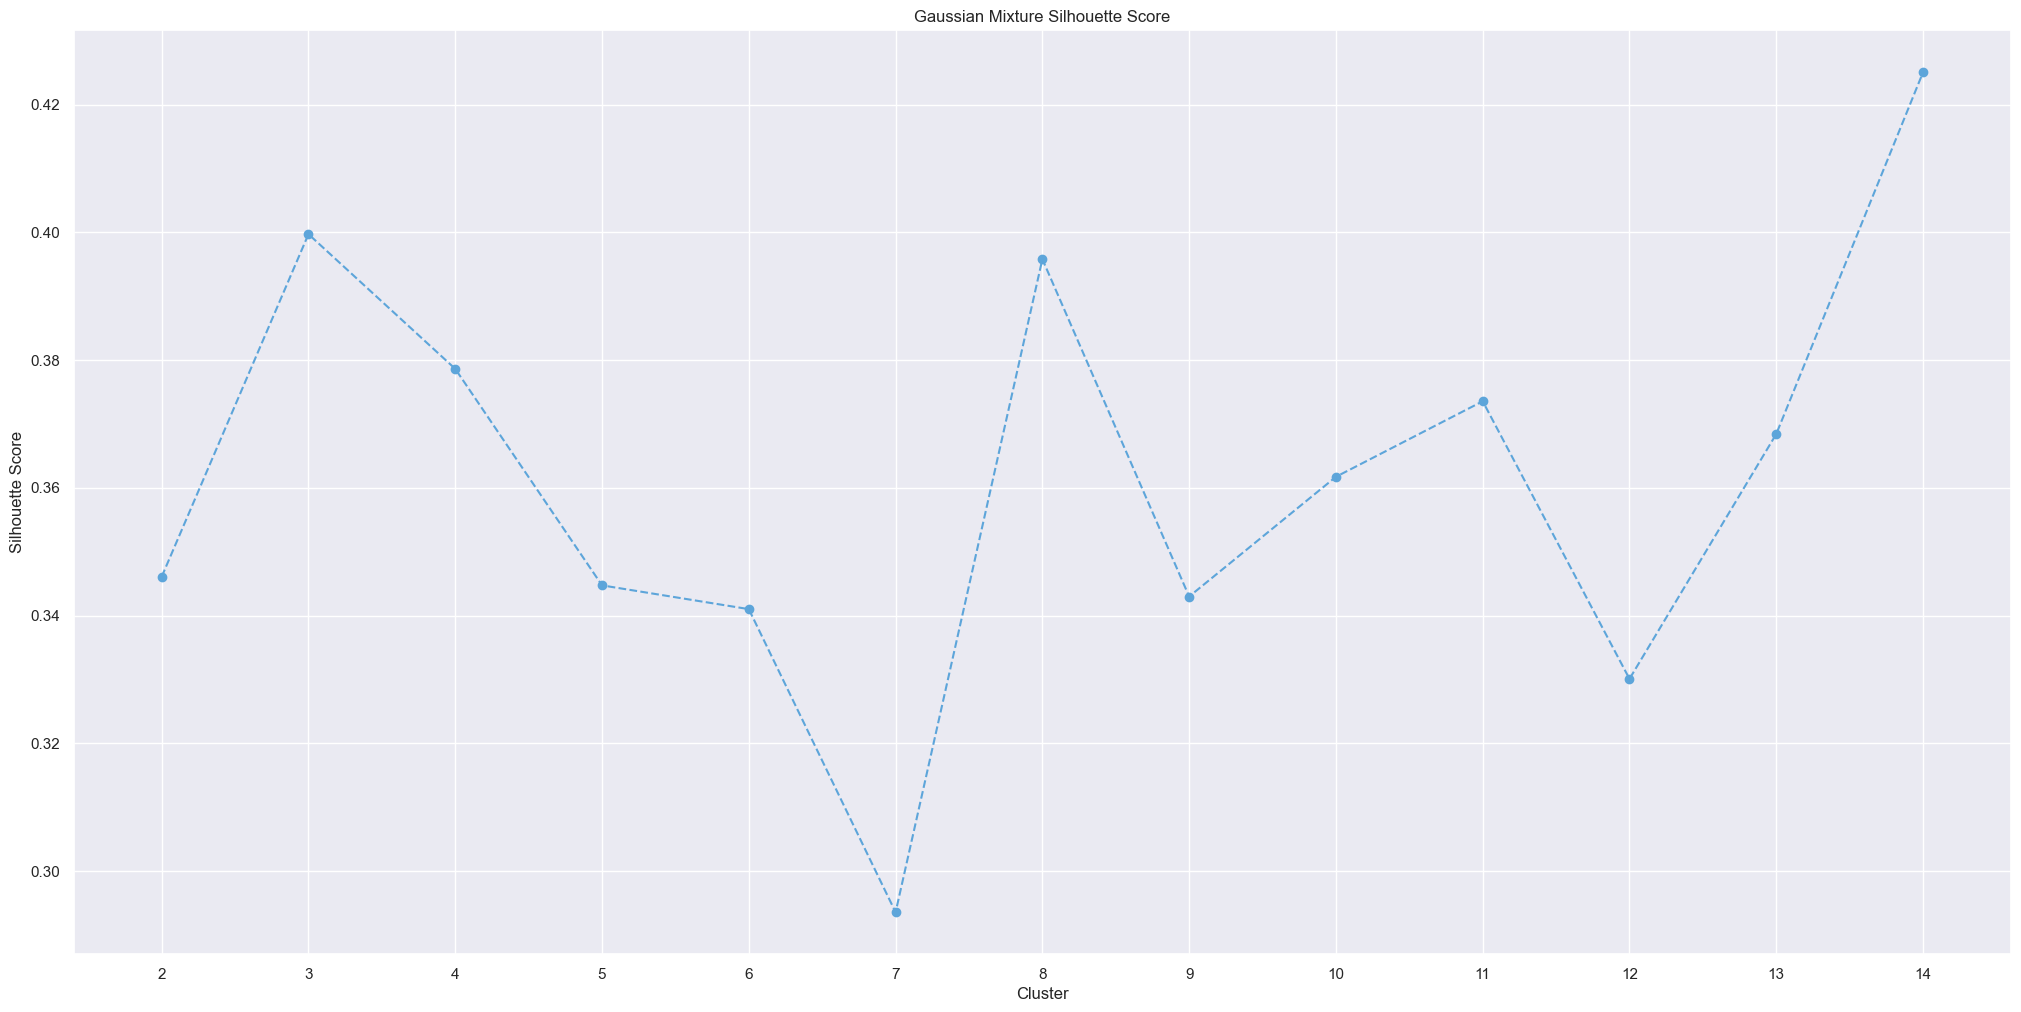

In [66]:
gm_ss = silhouette_score_result(clusters, gm_list, "#5DA5DA")

Pela falta de tempo, não foi possível utilizar outros métodos e clusters, então o silhouette score mais alto foi de apenas 0,43 com 14 clusters, que será o resultado escolhido.

In [67]:
model = GaussianMixture(n_components=14)

# model training
model.fit(X)

GaussianMixture(n_components=14)

In [80]:
labels = model.predict(X)
df_tree["cluster"] = labels
df_tree.head()

,embedding_x,embedding_y,clusters,cluster
0,-3.721688,7.879742,2,2
1,2.899131,-10.106888,11,11
2,11.000656,2.695718,13,13
3,-13.217820,12.922915,6,6
4,-4.369858,7.904801,2,2


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

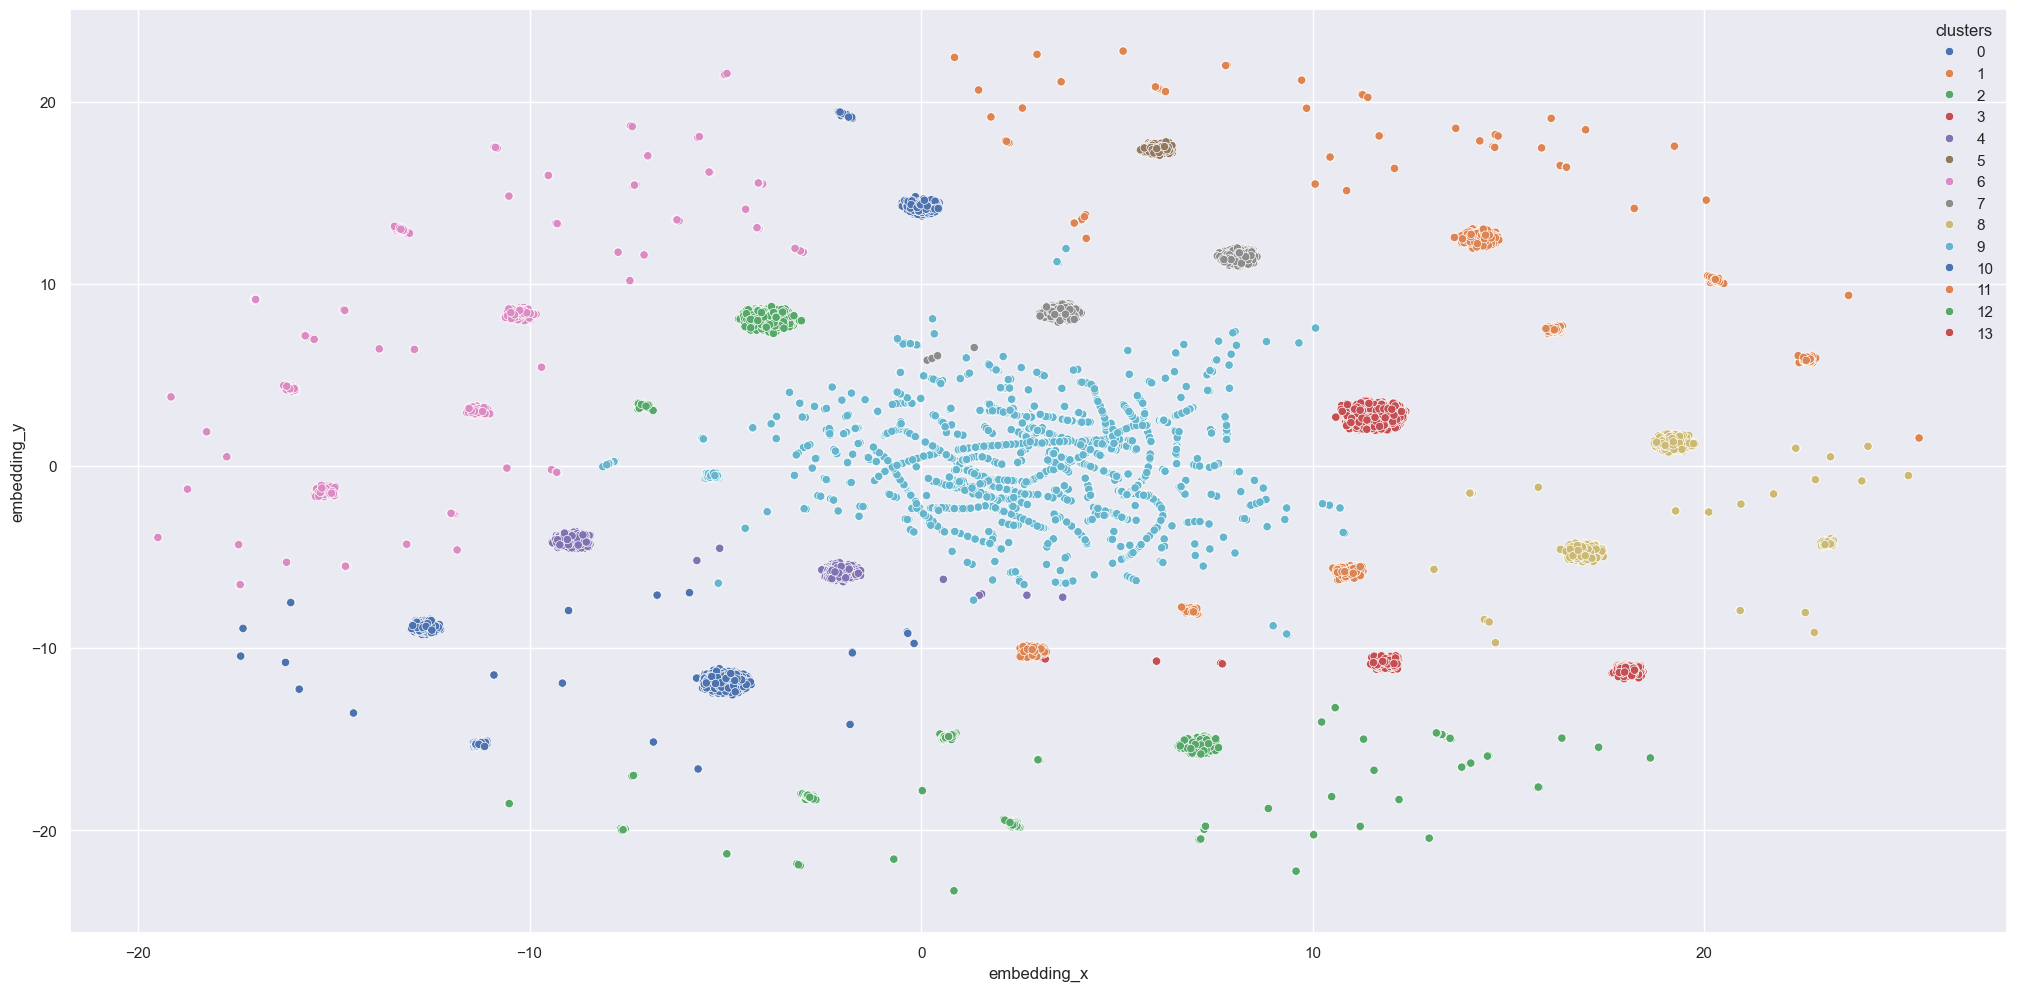

In [81]:
sns.scatterplot(
    x="embedding_x", y="embedding_y", hue="clusters", data=df_tree, palette="deep"
)

In [82]:
df3["cluster"] = labels
clusters_info = df3.copy()
clusters_info.head().T

,0,1,2,3,4
invoice_no,I138884,I317333,I127801,I337046,I227836
customer_id,C241288,C111565,C266599,C189076,C657758
gender,Female,Male,Male,Female,Female
age,28,21,20,53,28
category,Clothing,Shoes,Clothing,Books,Clothing
quantity,5,3,1,4,5
price,1500.4,1800.51,300.08,60.6,1500.4
payment_method,Credit Card,Debit Card,Cash,Cash,Credit Card
invoice_date,2022-08-05 00:00:00,2021-12-12 00:00:00,2021-11-09 00:00:00,2021-10-24 00:00:00,2022-05-24 00:00:00
shopping_mall,Kanyon,Forum Istanbul,Metrocity,Kanyon,Forum Istanbul


In [85]:
# number of customers
df_cluster = (
    clusters_info[["customer_id", "cluster"]].groupby("cluster").count().reset_index()
)
df_cluster["perc_customer"] = 100 * (
    df_cluster["customer_id"] / df_cluster["customer_id"].sum()
)

# avg_recency
df_avg_recency = (
    clusters_info[["recency", "cluster"]].groupby("cluster").mean().reset_index()
)
df_cluster = pd.merge(df_cluster, df_avg_recency, how="inner", on="cluster")

# avg_frequency
df_avg_frequency = (
    clusters_info[["frequency", "cluster"]].groupby("cluster").mean().reset_index()
)
df_cluster = pd.merge(df_cluster, df_avg_frequency, how="inner", on="cluster")

# avg_monetary
df_avg_monetary = (
    clusters_info[["monetary", "cluster"]].groupby("cluster").mean().reset_index()
)
df_cluster = pd.merge(df_cluster, df_avg_monetary, how="inner", on="cluster")

# quantity_of_items_purchased
df_q_items = (
    clusters_info[["quantity_of_items_purchased", "cluster"]]
    .groupby("cluster")
    .mean()
    .reset_index()
)
df_cluster = pd.merge(df_cluster, df_q_items, how="inner", on="cluster")

df_cluster

,cluster,customer_id,perc_customer,recency,frequency,monetary,quantity_of_items_purchased
0,0,8386,9.074677,457.659313,1.0,989.646067,2.330909
1,1,7931,8.582312,449.168579,1.0,987.352668,3.247384
2,2,6247,6.760018,395.362414,1.0,6328.664919,5.000000
3,3,4302,4.655290,384.633891,1.0,1258.680595,1.701767
4,4,5973,6.463516,397.769463,1.0,169.788500,4.492215
5,5,1971,2.132863,392.216134,1.0,896.000000,5.000000
6,6,9558,10.342925,414.401025,1.0,2333.102467,3.498640
7,7,6048,6.544675,397.435020,1.0,49.995499,2.007275
8,8,7451,8.062893,394.890484,1.0,501.909958,3.313649
9,9,10643,11.517027,285.055248,1.0,3340.138689,3.311378


## Respostas

### 1) Descreva a base dados fornecida:


A base de dados fornecida contém informações de comprras realizadas por clientes de 10 shoppings centers diferentes, possuindo 92.411 registros, nela contém:
- invoice_no: número da nota fiscal;
- customer_id: identificador único de cada cliente;
- gender: gênero do cliente
- age: idade do cliente
- category: categoria do produto comprado, podendo ser: Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys' 'Technology' 'Souvenir';
- quantidade: quantidade de itens comprados;
- price: preço unitária em Turkish Liras
- payment_method: forma de pagamento, podendo ser cartão de crédito, débito e dinheiro em espécie;
- invoice_date: data da transação
- shopping_mall: qual shopping é.

O preço possuía outliers na coluna price, especificamente em shoes e technology, mesmo fazendo sentido existirem compras nessas categorias de valores altos, por serem raros, presentes em menos de 8000 linhas, decidi removê-las.

Crie algumas features extras com informações de negócio, que são:
- gross_revenue: Receita bruta gerada pela compra.
- avg_ticket: Ticket médio da compra.
- quantity_of_items_purchased: Quantidade total de itens comprados.
- purchase_frequency: Frequência de compras do cliente.
- avg_basket_size: Tamanho médio da cesta de compras.
- recency: Recência da última compra.
- frequency: Frequência de compras (constante em 1, indicando que todos os clientes compraram ao menos uma vez).
- monetary: Valor monetário associado às compras do cliente.

### 2) Escolha um método de Classificação/Clusterização (e descreva-o), aplique na base de dados fornecida e identifique (e descreva) padrões/insights relevantes para uma empresa com essa base de dados;

Utilizei o UMAP e o PCA para redução de dimensionalidade que são não supervisionados e o Gaussian Mixture para escolher os clusters, também não supervisionado.

O PCA é um método linear de redução de dimensionalidade que transforma os dados para um novo sistema de coordenadas. Nesse caso, para visualização, fomos de 18 features para duas, ou seja, 18 dimensões para duas, o que auxilia na visualização mas atrapalha a explicabilidade.

O UMAP é um método não linear que preserva tanto a estrutura local quanto global dos dados ao projetá-los em um espaço de menor dimensão.

O Gaussian Mixture é um modelo probabilístico que tenta capturar a distribuição dos dados, permitindo que os clusters tenham diferentes formas e orientações. Ele se chama assim porque assume que os dados são gerados a partir de uma mistura de várias distribuições normais (gaussianas). Cada cluster é representado por uma gaussiana com seus próprios parâmetros (média e covariância).

In [92]:
df_cluster.round(2)

,cluster,customer_id,perc_customer,recency,frequency,monetary,quantity_of_items_purchased
0,0,8386,9.07,457.66,1.0,989.65,2.33
1,1,7931,8.58,449.17,1.0,987.35,3.25
2,2,6247,6.76,395.36,1.0,6328.66,5.00
3,3,4302,4.66,384.63,1.0,1258.68,1.70
4,4,5973,6.46,397.77,1.0,169.79,4.49
5,5,1971,2.13,392.22,1.0,896.00,5.00
6,6,9558,10.34,414.40,1.0,2333.10,3.50
7,7,6048,6.54,397.44,1.0,50.00,2.01
8,8,7451,8.06,394.89,1.0,501.91,3.31
9,9,10643,11.52,285.06,1.0,3340.14,3.31


Insights importantes por cluster

Cluster 0:
- **Insight**: Esse cluster tem uma recência alta, ou seja, os clientes não compraram recentemente, mas possuem um valor monetário considerável. A empresa poderia tentar reativar esses clientes com promoções ou campanhas de engajamento.

Cluster 1:
- **Insight**: Semelhante ao Cluster 0, com recência alta e valor monetário considerável. Investir em estratégias para incentivar novas compras, como ofertas direcionadas, pode ser eficaz.

Cluster 2:
- **Insight**: Esse é um cluster de alto valor com um número elevado de itens comprados e alta receita. São clientes muito valiosos, e a empresa deve focar em programas de fidelidade e personalização de ofertas.

Cluster 3:
- **Percentual de clientes**: 4.65%
- **Recência**: 384.63 dias
- **Monetário**: R$ 1258,68
- **Itens comprados**: 1.70 itens
- **Insight**: Embora o número de itens comprados seja baixo, o valor monetário é relativamente alto. A empresa pode investigar se esses clientes estão adquirindo produtos mais caros e investir em manter essa base fiel.

Cluster 4:
- **Insight**: Baixo valor monetário, mas alta quantidade de itens. Pode ser um grupo sensível a preços, então promoções com foco em descontos por volume podem ser atraentes.

Cluster 5:
- **Insight**: Mesmo com alto número de itens comprados, o valor monetário é relativamente baixo. Pode ser interessante incentivar esses clientes a gastar mais, talvez através de upselling.

Cluster 6:
- **Insight**: Um cluster relevante com um bom valor monetário. Ofertas que incentivem a compra de mais itens ou aumentem a frequência podem ser eficazes.

Cluster 7:
- **Insight**: Esse cluster tem baixo valor monetário, sugerindo que são clientes menos engajados ou de menor ticket médio. A empresa pode explorar estratégias para melhorar a experiência ou promover produtos com maior margem.

Cluster 8:
- **Insight**: Um cluster de médio valor. Incentivar esses clientes a aumentar a frequência de compras pode aumentar seu valor para a empresa.

Cluster 9:
- **Insight**: Esse cluster tem uma recência mais baixa e um valor monetário alto. São clientes ativos e valiosos. Continuar oferecendo boas experiências e recompensas pode ser uma boa estratégia de retenção.

Cluster 10:
- **Insight**: Um cluster de baixo valor, com poucas compras recentes. Investir em ações de engajamento pode ser uma maneira de reativá-los.

Cluster 11:
- **Insight**: Cluster de médio valor, com um bom potencial para crescer. Campanhas para aumentar o ticket médio ou a frequência podem ser eficazes.

Cluster 12:
- **Insight**: Um cluster de valor médio. Aumentar o engajamento desses clientes pode gerar um crescimento substancial para a empresa.

Cluster 13:
- **Insight**: Cluster de baixo valor com poucas compras. Ofertas promocionais e descontos podem ser boas estratégias para atrair mais engajamento.


Insights gerais para a empresa

- A empresa pode identificar **clientes de alto valor** nos clusters 2, 6 e 9, e focar em **estratégias de retenção** para esses grupos, oferecendo promoções personalizadas para mantê-los engajados.
- Clusters de **baixo valor monetário**, como os clusters 7, 10 e 13, podem ser alvo de **campanhas de reativação** especialmente focando em melhorar a experiência do cliente ou oferecer produtos de maior margem.
- A **recência alta** em muitos clusters sugere que muitos clientes não têm comprado recentemente, então deve-se focar em **campanhas de marketing** para ajudar a recuperar esses clientes inativos.

### 3) Qual a diferença dos métodos de Classificação para os de Clusterização?

Em Classificação, a ideia é atribuir rótulos conhecidos(classes) a novos dados, isso com base em exemplos que já foram realizados, nesse exemplo por exemplo,poderiámos prever a forma de pagamento utilizada dado as outras informações do cliente e o shopping que está, para isso, aplicaríamos os dados fornecidos em um model, dividindo em treino e teste, fornecendo os dados de treino, obteríamos um modelo capaz de classificar a forma de pagamento e verificaríamos se ele acerta as formas de pagamento do dado de teste, se sim, colocaríamos em prática. Exemplo de modelo: Catboost Classifier
Já em clusterização, o modelo não recebe rótulos nem é necessário a divisão de treino e teste, o objetivo é agrupar dados semelhantes com base em suas características, sem saber a que grupo pertencem, foi o utilizado, aqui podemos citar o PCA e GMM(Gaussian Mixture Model)